In [1]:
my_API = 'b7ZwBbmv3PtlRVdOVHaQXJwJuvkhmOVp'

In [2]:
!pip install pymatgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Import Libraries-----------------------------------------
import pandas as pd
from pymatgen.ext.matproj import MPRester
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [4]:
with MPRester(my_API) as mpr:
    docs = mpr.summary.search(
        elements=[],
        num_elements=[2, 2],
        exclude_elements=['Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf',
                          'Db', 'Sg','Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'],
        is_stable=True,
        fields=["material_id", "formation_energy_per_atom", "band_gap", "density_atomic", "formula_pretty", "total_magnetization", "efermi"]
    )

formula = [doc.formula_pretty for doc in docs]
len(formula)
print(formula)

/usr/local/lib/python3.10/dist-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/5149 [00:00<?, ?it/s]

['Mg149Tc', 'K5As4', 'CuS2', 'Sm14Ag51', 'GdB6', 'Th2C3', 'YIr', 'TmSe2', 'ZrCr2', 'CaCu5', 'NdOs2', 'Ho2S3', 'NiCl2', 'SnRh', 'Zr7Pt10', 'Nd5Co2', 'Ac2O3', 'Er13Zn58', 'Au3F8', 'EuMg2', 'P4S3', 'Tm3Ru', 'GdSe2', 'Tl7Sb2', 'Ho2In', 'TaSi2', 'Ti2O', 'La5Ru2', 'Dy13Zn58', 'Zn3N2', 'In4Te3', 'TaAs', 'EuPb', 'BeH2', 'ZrSe2', 'SmH2', 'Ag3Pd', 'Tb11Sn10', 'Ti2Pd', 'Yb3Ge8', 'Li17Sn4', 'EuHg3', 'Ca5Au3', 'Sr3P4', 'Mg149In', 'NaCl7', 'Nb3B4', 'PtPb4', 'U3Sb4', 'TbBr3', 'BaF3', 'Yb5Pt3', 'Sb2Os', 'Th2Se3', 'PrSe2', 'Nb5Sb4', 'TeI', 'Nb2Pd', 'Tb2Co17', 'Ho2C', 'Rb4Ge23', 'TbZn2', 'HoHg3', 'GaBr3', 'BaMg', 'RbI', 'Tm3Ir', 'Zr3In', 'CrRh3', 'TmB2', 'Pr5Bi3', 'Dy3Ga5', 'DyRe2', 'Ba3N', 'Tm5Rh3', 'Cd41Ir8', 'CoSb', 'Pa3Te', 'Ca5Si3', 'Y2Se3', 'CsGa3', 'FePt3', 'Mo5As4', 'Ag3Sb', 'Lu2Se3', 'Nb2B3', 'ZrRh3', 'Yb2Ni7', 'BaZn2', 'PmHg3', 'In2O3', 'Tm11Cd45', 'TbIr2', 'Nd5Rh4', 'CrPt3', 'AlV3', 'PrMg', 'Zr2Al3', 'GaCo', 'MgTl', 'Li3Cd', 'Dy3Rh2', 'Cs3P7', 'La7Ru3', 'PrTl', 'Tl2O', 'Tc2As3', 'EuS2', 'Yb5A

In [5]:
df = {"material_id": [], "density_atomic": [], "band_gap": [], "formula": [], "formation_energy_per_atom": [], "total_magnetization": [],"efermi":[]}
for doc in docs:
    df['material_id'].append(doc.material_id)
    df['density_atomic'].append(doc.density_atomic)
    df['band_gap'].append(doc.band_gap)
    df['formula'].append(doc.formula_pretty)
    df['formation_energy_per_atom'].append(doc.formation_energy_per_atom)
    df['total_magnetization'].append(doc.total_magnetization)
    df['efermi'].append(doc.efermi)

df = pd.DataFrame(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149 entries, 0 to 5148
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   material_id                5149 non-null   object 
 1   density_atomic             5149 non-null   float64
 2   band_gap                   5149 non-null   float64
 3   formula                    5149 non-null   object 
 4   formation_energy_per_atom  5149 non-null   float64
 5   total_magnetization        5149 non-null   float64
 6   efermi                     5145 non-null   float64
dtypes: float64(5), object(2)
memory usage: 281.7+ KB


In [6]:
#number of unique compositions

df["formula"].astype("string").unique()


<StringArray>
[ 'Mg149Tc',    'K5As4',     'CuS2', 'Sm14Ag51',     'GdB6',    'Th2C3',
      'YIr',    'TmSe2',    'ZrCr2',    'CaCu5',
 ...
     'Zr3O',      'PI3',      'V2N',     'TmPd',    'Zr3Te',    'Mg2Ge',
     'Si2W',      'FeO',    'CeRh3',    'AsPd2']
Length: 5149, dtype: string

In [7]:
from pymatgen.core import periodic_table

# Read the periodic table data
periodic_table = pd.read_csv('periodic_table_final.csv')
periodic_table.set_index("Symbol", inplace=True)

AR = periodic_table.loc["O", "AtomicRadius"]  # Accessing atomic radius for oxygen (O)
AM = periodic_table.loc["O", "AtomicMass"]  # Accessing atomic mass for oxygen (O)

formula = [doc.formula_pretty for doc in docs]
print(formula)

print("Atomic Radius of O:", AR)
print("Atomic Mass of O:", AM)
from pymatgen.core import Composition


comp =Composition('CuS2')
print(comp)
comp.elements # this will give you the elements
comp.get_atomic_fraction('Cu') # this will give you the atomic fraction of Cu in CuS2
comp.weight #molecular weight of CuS2

['Mg149Tc', 'K5As4', 'CuS2', 'Sm14Ag51', 'GdB6', 'Th2C3', 'YIr', 'TmSe2', 'ZrCr2', 'CaCu5', 'NdOs2', 'Ho2S3', 'NiCl2', 'SnRh', 'Zr7Pt10', 'Nd5Co2', 'Ac2O3', 'Er13Zn58', 'Au3F8', 'EuMg2', 'P4S3', 'Tm3Ru', 'GdSe2', 'Tl7Sb2', 'Ho2In', 'TaSi2', 'Ti2O', 'La5Ru2', 'Dy13Zn58', 'Zn3N2', 'In4Te3', 'TaAs', 'EuPb', 'BeH2', 'ZrSe2', 'SmH2', 'Ag3Pd', 'Tb11Sn10', 'Ti2Pd', 'Yb3Ge8', 'Li17Sn4', 'EuHg3', 'Ca5Au3', 'Sr3P4', 'Mg149In', 'NaCl7', 'Nb3B4', 'PtPb4', 'U3Sb4', 'TbBr3', 'BaF3', 'Yb5Pt3', 'Sb2Os', 'Th2Se3', 'PrSe2', 'Nb5Sb4', 'TeI', 'Nb2Pd', 'Tb2Co17', 'Ho2C', 'Rb4Ge23', 'TbZn2', 'HoHg3', 'GaBr3', 'BaMg', 'RbI', 'Tm3Ir', 'Zr3In', 'CrRh3', 'TmB2', 'Pr5Bi3', 'Dy3Ga5', 'DyRe2', 'Ba3N', 'Tm5Rh3', 'Cd41Ir8', 'CoSb', 'Pa3Te', 'Ca5Si3', 'Y2Se3', 'CsGa3', 'FePt3', 'Mo5As4', 'Ag3Sb', 'Lu2Se3', 'Nb2B3', 'ZrRh3', 'Yb2Ni7', 'BaZn2', 'PmHg3', 'In2O3', 'Tm11Cd45', 'TbIr2', 'Nd5Rh4', 'CrPt3', 'AlV3', 'PrMg', 'Zr2Al3', 'GaCo', 'MgTl', 'Li3Cd', 'Dy3Rh2', 'Cs3P7', 'La7Ru3', 'PrTl', 'Tl2O', 'Tc2As3', 'EuS2', 'Yb5A

127.67599999999999

Feature engineering

In [8]:
Ave_Electronegativity_list = []
Ave_atomic_mass_list = []
Ave_atomic_radius_list = []
Ave_atomic_number_list = []
Ave_number_of_neutrons_list = []
Ave_first_ionization_energy_list = []
Ave_melting_point_list = []
Ave_boiling_point_list = []
Ave_NumberOfIsotopes_list=[]
for i in range(len(df['formula'])):
    comp = Composition(df['formula'][i])
    elements = comp.elements

    Ave_atomic_mass = (periodic_table.loc[elements[0].symbol, 'AtomicMass'] * comp.get_atomic_fraction(elements[0]) +
                       periodic_table.loc[elements[1].symbol, 'AtomicMass'] * comp.get_atomic_fraction(elements[1]))

    Ave_Electronegativity = (periodic_table.loc[elements[0].symbol, 'Electronegativity'] *
                             comp.get_atomic_fraction(elements[0]) +
                             periodic_table.loc[elements[1].symbol, 'Electronegativity'] *
                             comp.get_atomic_fraction(elements[1]))

    Ave_atomic_radius = (periodic_table.loc[elements[0].symbol, 'AtomicRadius'] *
                         comp.get_atomic_fraction(elements[0]) +
                         periodic_table.loc[elements[1].symbol, 'AtomicRadius'] *
                         comp.get_atomic_fraction(elements[1]))

    Ave_atomic_number = (periodic_table.loc[elements[0].symbol, 'AtomicNumber'] * comp.get_atomic_fraction(elements[0]) +
                         periodic_table.loc[elements[1].symbol, 'AtomicNumber'] * comp.get_atomic_fraction(elements[1]))

    Ave_number_of_neutrons = (periodic_table.loc[elements[0].symbol, 'NumberofNeutrons'] *
                              comp.get_atomic_fraction(elements[0]) +
                              periodic_table.loc[elements[1].symbol, 'NumberofNeutrons'] *
                              comp.get_atomic_fraction(elements[1]))

    Ave_first_ionization_energy = (periodic_table.loc[elements[0].symbol, 'FirstIonization'] *
                                   comp.get_atomic_fraction(elements[0]) +
                                   periodic_table.loc[elements[1].symbol, 'FirstIonization'] *
                                   comp.get_atomic_fraction(elements[1]))

    Ave_melting_point = (periodic_table.loc[elements[0].symbol, 'MeltingPoint'] *
                         comp.get_atomic_fraction(elements[0]) +
                         periodic_table.loc[elements[1].symbol, 'MeltingPoint'] *
                         comp.get_atomic_fraction(elements[1]))

    Ave_boiling_point = (periodic_table.loc[elements[0].symbol, 'BoilingPoint'] *
                         comp.get_atomic_fraction(elements[0]) +
                         periodic_table.loc[elements[1].symbol, 'BoilingPoint'] *
                         comp.get_atomic_fraction(elements[1]))
    Ave_NumberOfIsotopes = (periodic_table.loc[elements[0].symbol, 'NumberOfIsotopes']*comp.get_atomic_fraction(elements[0])+periodic_table.loc[elements[1].symbol, 'NumberOfIsotopes']*comp.get_atomic_fraction(elements[1]))

    Ave_Electronegativity_list.append(Ave_Electronegativity)
    Ave_atomic_mass_list.append(Ave_atomic_mass)
    Ave_atomic_radius_list.append(Ave_atomic_radius)
    Ave_atomic_number_list.append(Ave_atomic_number)
    Ave_number_of_neutrons_list.append(Ave_number_of_neutrons)
    Ave_first_ionization_energy_list.append(Ave_first_ionization_energy)
    Ave_melting_point_list.append(Ave_melting_point)
    Ave_boiling_point_list.append(Ave_boiling_point)
    Ave_NumberOfIsotopes_list.append(Ave_NumberOfIsotopes)

df['Ave_Electronegativity'] = Ave_Electronegativity_list
df['Ave_atomic_mass'] = Ave_atomic_mass_list
df['Ave_atomic_radius'] = Ave_atomic_radius_list
df['Ave_atomic_number'] = Ave_atomic_number_list
df['Ave_number_of_neutrons'] = Ave_number_of_neutrons_list
df['Ave_first_ionization_energy'] = Ave_first_ionization_energy_list
df['Ave_melting_point'] = Ave_melting_point_list
df['Ave_boiling_point'] = Ave_boiling_point_list
df['Ave_NumberOfIsotopes'] = Ave_NumberOfIsotopes_list


t = 0.001
metal_nonmetal_list=[]
for index, row in df.iterrows():
  if row['band_gap'] < t:
    df.at[index, 'metal_nonmetal_list'] = '1' #non-metallic
  else:
    df.at[index, 'metal_nonmetal_list'] = '0'  #metallic


In [9]:
# Check for missing values
missing_values = df.isnull().sum()

# Replace missing values with 0
df.fillna(0, inplace=True)

# Verify if missing values have been replaced
missing_values_after_replacement = df.isnull().sum()


df

,material_id,density_atomic,band_gap,formula,formation_energy_per_atom,total_magnetization,efermi,Ave_Electronegativity,Ave_atomic_mass,Ave_atomic_radius,Ave_atomic_number,Ave_number_of_neutrons,Ave_first_ionization_energy,Ave_melting_point,Ave_boiling_point,Ave_NumberOfIsotopes,metal_nonmetal_list
0,mp-1185636,22.877356,0.0978,Mg149Tc,-0.018674,1.226160e-02,3.331855,1.313933,24.796300,1.702000,12.206667,12.286667,7.643759,933.483333,1388.246667,8.100000,0
1,mp-1223503,32.273652,0.0000,K5As4,-0.437151,0.000000e+00,1.684900,1.424444,55.019778,2.133333,25.222222,29.777778,6.761989,671.455556,967.555556,11.777778,1
2,mp-849086,16.316454,0.0000,CuS2,-0.432674,0.000000e+00,6.011833,2.353333,42.558667,1.266667,20.333333,22.333333,9.482133,711.590000,1423.533333,10.333333,1
3,mp-1219378,20.401661,0.0000,Sm14Ag51,-0.246306,2.000000e-07,3.305880,1.766308,117.020123,1.972308,50.230769,66.815385,7.159969,1258.057692,2355.738462,24.846154,1
4,mp-22266,9.856148,0.0000,GdB6,-0.456620,6.839141e+00,6.356128,1.920000,31.730857,1.385714,13.428571,18.428571,7.991157,2432.007143,4106.571429,7.571429,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,mp-408,21.525290,0.1520,Mg2Ge,-0.268911,0.000000e+00,3.300605,1.543333,40.416667,1.633333,18.666667,21.666667,7.730600,1019.250000,1944.000000,11.000000,0
5145,mp-1620,13.438418,0.0000,Si2W,-0.345997,0.000000e+00,10.164066,2.053333,80.004000,1.666667,34.000000,46.000000,8.055800,2348.816667,4301.333333,12.666667,1
5146,mp-1274279,10.623560,1.8157,FeO,-1.482156,2.000000e-07,4.160448,2.635000,35.922000,1.175000,17.000000,19.000000,10.760250,929.325000,1612.100000,9.000000,0
5147,mp-1518,16.443801,0.0000,CeRh3,-0.634512,1.120000e-05,7.900701,1.990000,112.208500,2.025000,48.250000,64.000000,6.978850,1947.150000,3905.000000,19.750000,1


In [10]:
# for classification andvfeature importance analysis
df1 = df.copy()
df1.drop(columns = ['material_id'], inplace = True)
df1.drop(columns = ['formula'], inplace = True)
df1.drop(columns = ['metal_nonmetal_list'], inplace = True)
df1.drop(columns = ['formation_energy_per_atom'], inplace = True)
df1.drop(columns = ['efermi'], inplace = True)
df1.drop(columns = ['total_magnetization'], inplace = True)

df1.head()
df1.dropna(inplace=True)

df2 = df.copy()
df2.drop(columns = ['material_id'], inplace = True)
df2.drop(columns = ['formula'], inplace = True)
df2.drop(columns = ['band_gap'] , inplace = True)
df2.dropna(inplace = True)

Regression Models

Linear Regression

In [11]:
#spliting the dataset
from sklearn.model_selection import train_test_split
Y = df['formation_energy_per_atom']
X = df[['density_atomic', 'band_gap','metal_nonmetal_list' ,'Ave_Electronegativity', 'Ave_atomic_mass', 'efermi', 'total_magnetization','Ave_atomic_radius','Ave_atomic_number','Ave_number_of_neutrons','Ave_first_ionization_energy','Ave_melting_point','Ave_boiling_point','Ave_NumberOfIsotopes']]

In [12]:

# 20% trian
X_train_val, X_test, y_train_val, y_test = train_test_split(X,Y,test_size=.2,random_state=42)
# 20% Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=42)


density_atomic: -0.007917066627081708
band_gap: -0.2315006340466533
metal_nonmetal_list: -0.043286209220775536
Ave_Electronegativity: -0.914412055200178
Ave_atomic_mass: 0.1343416286305606
efermi: -0.06397350334063467
total_magnetization: -0.0029482184841525395
Ave_atomic_radius: -1.5126875938923885
Ave_atomic_number: -0.10051070066923347
Ave_number_of_neutrons: -0.15046577110638268
Ave_first_ionization_energy: -0.16070365410826803
Ave_melting_point: 5.391731547380041e-05
Ave_boiling_point: 9.510557133579622e-05
Ave_NumberOfIsotopes: 0.005166356662776579


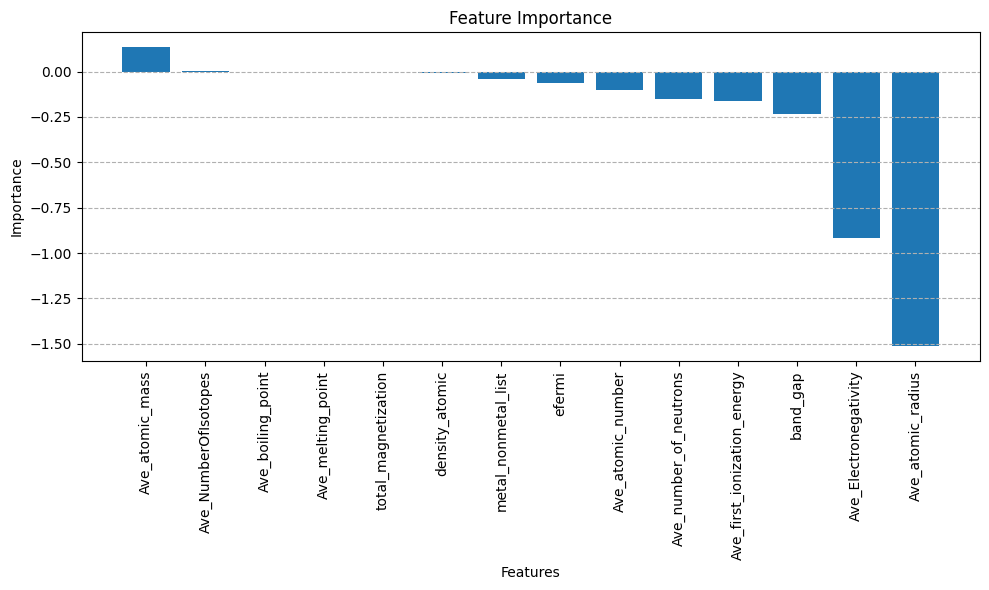

In [13]:
from sklearn.linear_model import LinearRegression


# Create a Linear Regression model
linear_regression = LinearRegression()

# Fit the model to the data
linear_regression.fit(X, Y)

# Get the coefficients (feature weights) of the linear regression model
feature_importance = linear_regression.coef_

# Print the feature importance values
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance}")

import matplotlib.pyplot as plt
import numpy as np


# Sort the feature importances and corresponding feature names in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_features = np.array(X.columns)[sorted_indices]

# Create a bar plot of sorted feature importances
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(range(len(sorted_features)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)  # Set x-axis labels
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--')

# Adjust spacing and padding
plt.tight_layout()

plt.show()



In [14]:
# Linear Regression----------------------------------------------------------
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

Mean Squared Error:  0.27611153385398357
R^2 Value: 0.5040392408027228


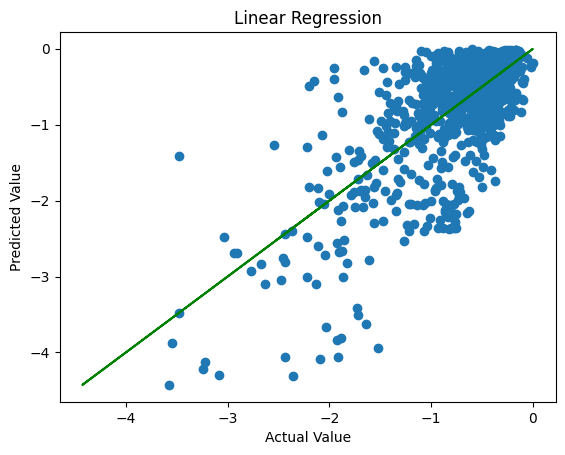

In [15]:
# Linear Regression----------------------------------------------------------
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
#Looking to see if prediction follows actual data
predictions = regressor.predict(X_test)
mse_r = mean_squared_error(y_test,regressor.predict(X_test))
mae_r = mean_absolute_error(y_test,regressor.predict(X_test))
r2_r = r2_score(y_test,regressor.predict(X_test))
print('Mean Squared Error: ',mse_r)
print('R^2 Value:',r2_r)
plt.scatter(regressor.predict(X_test),y_test)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Linear Regression')
plt.plot(y_test,y_test,color='g')

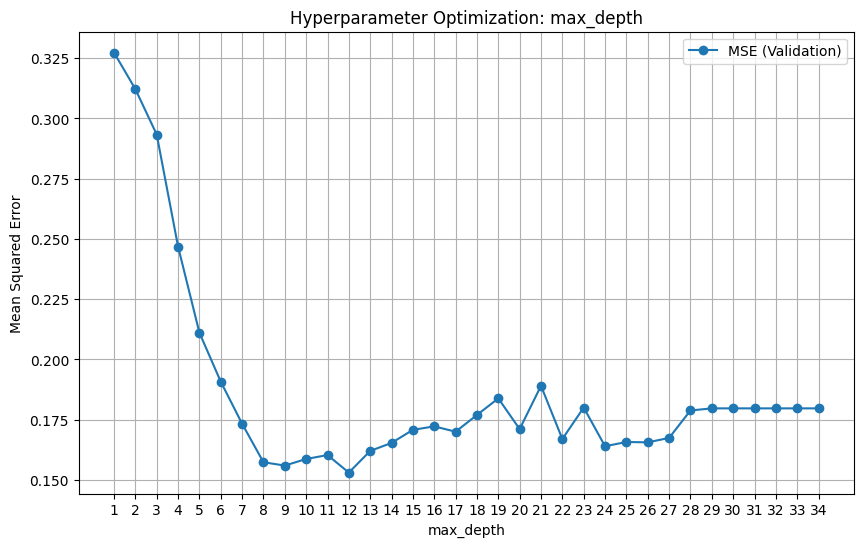

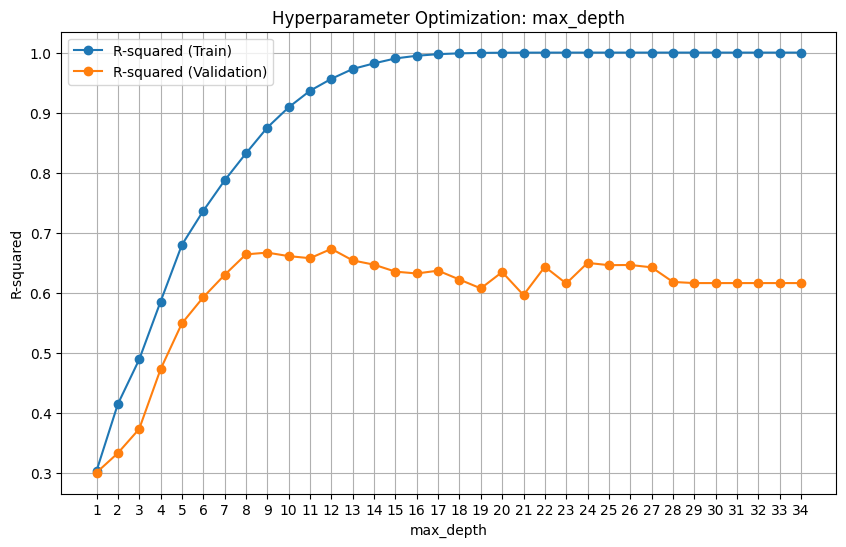

In [16]:
# DecisionTreeRegressor Model

model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

# Define a range of max_depth values to try
max_depth_values = range(1, 35)

# Initialize lists to store MSE and R-squared values for train, validation, and test sets
mse_train_values = []
r2_train_values = []
mse_val_values = []
r2_val_values = []
mse_test_values = []
r2_test_values = []
# Hyperparameter optimization loop
for i in max_depth_values:
    # Create and train the decision tree regression model
    model = DecisionTreeRegressor(max_depth=i,random_state=42)
    model.fit(X_train, y_train)
    # Make predictions on the train set
    y_train_pred = model.predict(X_train)
    # Compute MSE and R-squared for train set
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)
    # Compute MSE and R-squared for validation set
    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    # Make predictions on the test set
    y_test_pred = model.predict(X_test)
    # Compute MSE and R-squared for test set
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    # Append the results to the lists
    mse_train_values.append(mse_train)
    r2_train_values.append(r2_train)
    mse_val_values.append(mse_val)
    r2_val_values.append(r2_val)
    mse_test_values.append(mse_test)
    r2_test_values.append(r2_test)
# Plotting the results
plt.figure(figsize=(10, 6))



plt.plot(max_depth_values, mse_val_values, 'o-', label='MSE (Validation)')

plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.title('Hyperparameter Optimization: max_depth')
plt.xticks(max_depth_values)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, r2_train_values, 'o-', label='R-squared (Train)')
plt.plot(max_depth_values, r2_val_values, 'o-', label='R-squared (Validation)')
plt.xlabel('max_depth')
plt.ylabel('R-squared')
plt.title('Hyperparameter Optimization: max_depth')
plt.xticks(max_depth_values)
plt.grid(True)
plt.legend()
plt.show()

Mean Squared Error Validation: 0.15862283602508737
R-squared Validation: 0.6608384418192572
Mean Squared Error Testing: 0.1991480877730343
R-squared Testing: 0.6422835532222548


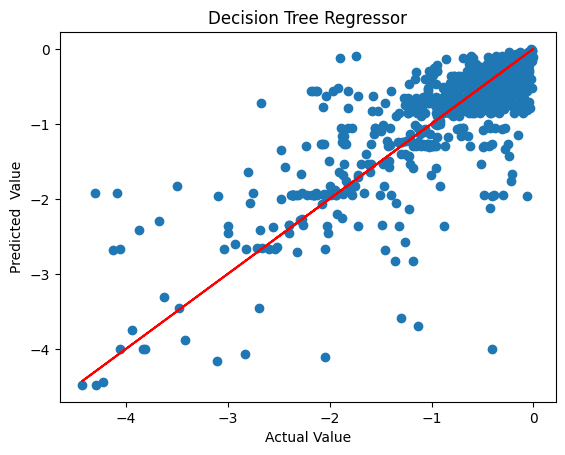

In [17]:
# Testing the data to determine a good fit for the points

import matplotlib.pyplot as plt
import seaborn as sns
# Train the model
model = DecisionTreeRegressor(max_depth=10,random_state=42)
model.fit(X_train, y_train)
# Make predictions on the validation set
y_pred = model.predict(X_val)
# Calculate evaluation metrics on the validation set
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("Mean Squared Error Validation:", mse)
print("R-squared Validation:", r2)
# Make predictions on the TESTING set
y_pred = model.predict(X_test)
# Calculate evaluation metrics on the TESTING set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error Testing:", mse)
print("R-squared Testing:", r2)
# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test,color='r')
plt.xlabel("Actual Value")
plt.ylabel("Predicted  Value")
plt.title("Decision Tree Regressor")
plt.show()

Random Forest Regression Model

In [18]:
#gridsearch to determine the best hyperparameters.
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
param_grid = {
    'max_depth': [3,5,7,9,12],
    'min_samples_split': [2 , 3],
    'n_estimators': [50, 100,150, 200]
}
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)
# Evaluate on the validation set
validation_predictions = best_model.predict(X_val)
mse_validation = mean_squared_error(y_val, validation_predictions)
r2_validation = r2_score(y_val, validation_predictions)
print("Best Parameters:", best_params)
print("Best Mean Squared Error:", -best_score)
print("Validation Set - Mean Squared Error:", mse_validation)
print("Validation Set - R-squared:", r2_validation)

Best Parameters: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 200}
Best Mean Squared Error: 0.09990110514534394
Validation Set - Mean Squared Error: 0.10541993058405817
Validation Set - R-squared: 0.81765098298091


Mean Squared Error VALIDATION: 0.10322690370159819
R-squared VALIDATION: 0.8214443481832723
Mean Squared Error TESTING: 0.11386011997278789
R-squared TESTING: 0.795480649591914


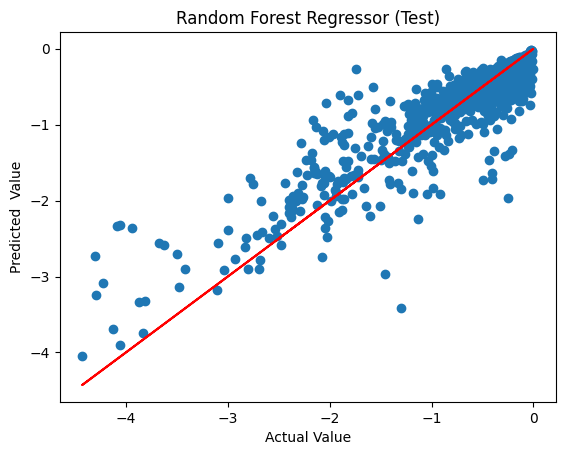

In [19]:
#Testing data  - Random Forest regressor(Test) for predicted vs actual values
import matplotlib.pyplot as plt
import seaborn as sns
# Train the model
model = RandomForestRegressor(n_estimators=300)
model.fit(X_train, y_train)
# Make predictions on the validation set
y_pred = model.predict(X_val)
# Calculate evaluation metrics on the validation set
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("Mean Squared Error VALIDATION:", mse)
print("R-squared VALIDATION:", r2)
# Make predictions on the TESTING set
y_pred = model.predict(X_test)
# Calculate evaluation metrics on the TESTING set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error TESTING:", mse)
print("R-squared TESTING:", r2)
# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test,color='r')
plt.xlabel("Actual Value")
plt.ylabel("Predicted  Value")
plt.title("Random Forest Regressor (Test)")
plt.show()

 Classification Models Decision Tree Classification, Random Forest Classification

In [20]:
# defining X and y for the classification models:
from sklearn.model_selection import train_test_split
y = df['metal_nonmetal_list']

# Assign the features (X)
X = df[['density_atomic' ,'formation_energy_per_atom', 'Ave_Electronegativity', 'Ave_atomic_mass', 'efermi', 'total_magnetization','Ave_atomic_radius','Ave_atomic_number','Ave_number_of_neutrons','Ave_first_ionization_energy','Ave_melting_point','Ave_boiling_point','Ave_NumberOfIsotopes']]


In [21]:
# Testing and training data sets
# 20% train
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=.2,random_state=0)
# 20% Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=0)

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [23]:
# Decision Tree Classifier
# Create a model and train it
model = DecisionTreeClassifier(criterion ="entropy" ,max_depth = 3)
model.fit(X_train, y_train)
# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Accuracy score
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.8661608497723824
0.8572815533980582


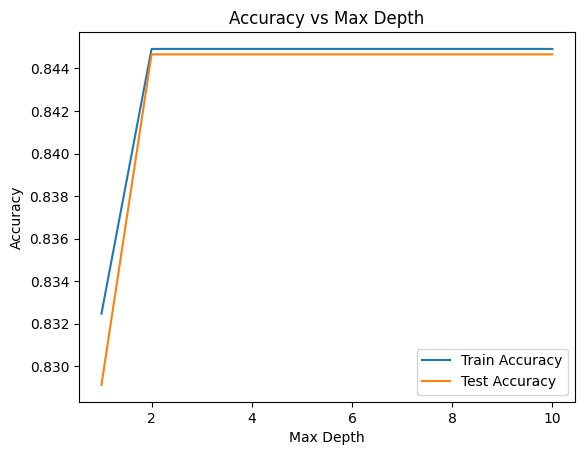

In [24]:
#plotting accuracy verse max depth to compare test and train accuracy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Define the range of max_depth values to test
max_depth_values = np.arange(1, 11)
# Create empty lists to store accuracy scores
train_accuracy = []
test_accuracy = []
# Iterate over different max_depth values
for max_depth in max_depth_values:
    # Create a model and train it
    model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth,max_leaf_nodes=6)
    model.fit(X_train, y_train)
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Calculate accuracy scoresfor
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    # Append accuracy scores to the lists
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
# Plot the accuracy scores
plt.plot(max_depth_values, train_accuracy, label='Train Accuracy')
plt.plot(max_depth_values, test_accuracy, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()

Random Forest classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

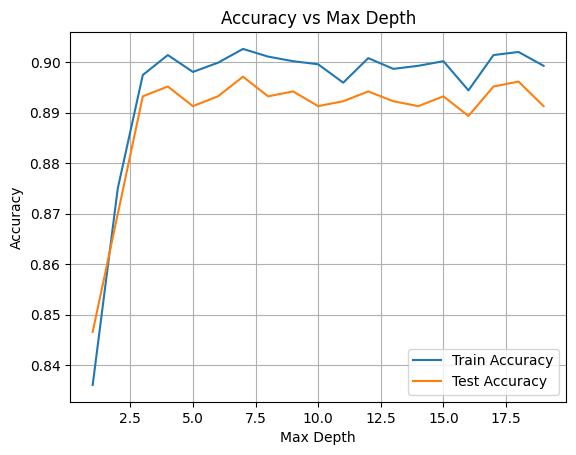

In [26]:
# Define the range of max_depth values to test -  plotting accuracy verse max depth
max_depth_values = np.arange(1, 20)
# Create empty lists to store accuracy scores
train_accuracy = []
test_accuracy = []
# Iterate over different max_depth values
for max_depth in max_depth_values:
    # Create a model and train it
    model = RandomForestClassifier(criterion="entropy", max_depth=max_depth,max_leaf_nodes=6)
    model.fit(X_train, y_train)
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    # Append accuracy scores to the lists
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
# Plot the accuracy scores
plt.plot(max_depth_values, train_accuracy, label='Train Accuracy')
plt.plot(max_depth_values, test_accuracy, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.grid(True)
plt.legend()
plt.show()

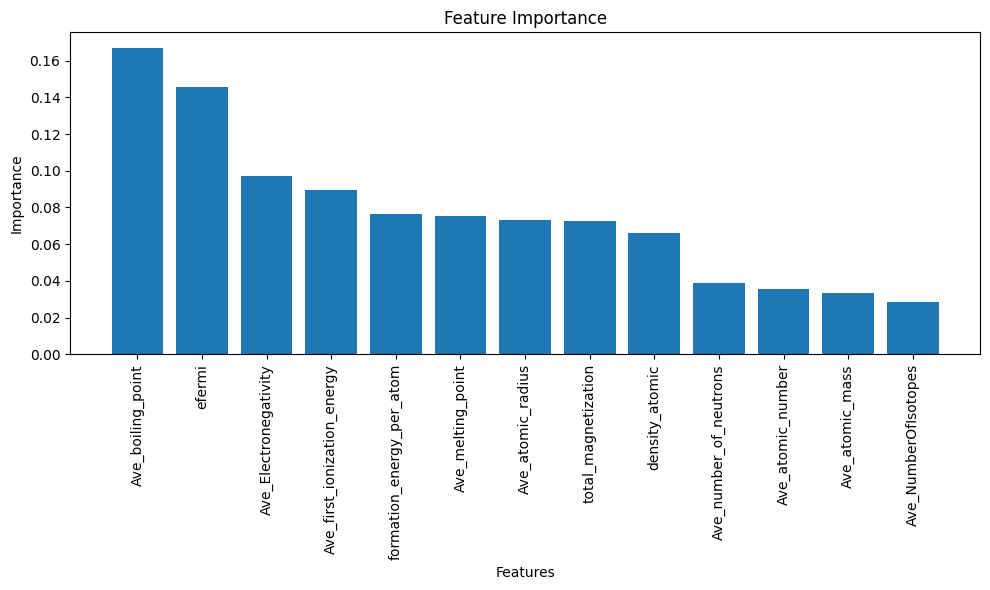

In [27]:
##Feature importance for a random forest classification model
# Extract the feature names
feature_names = df2.columns[:-1]  # Assuming the target variable is in the last column
# Split the data into features (X) and target variable (y)
X = df2.iloc[:, :-1]  # Assuming the target variable is in the last column
y = df2.iloc[:, -1]   # Assuming the target variable is in the last column
# Fit a Random Forest regressor
clf = RandomForestClassifier()
clf.fit(X, y)
# Get feature importances
importances = clf.feature_importances_
# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

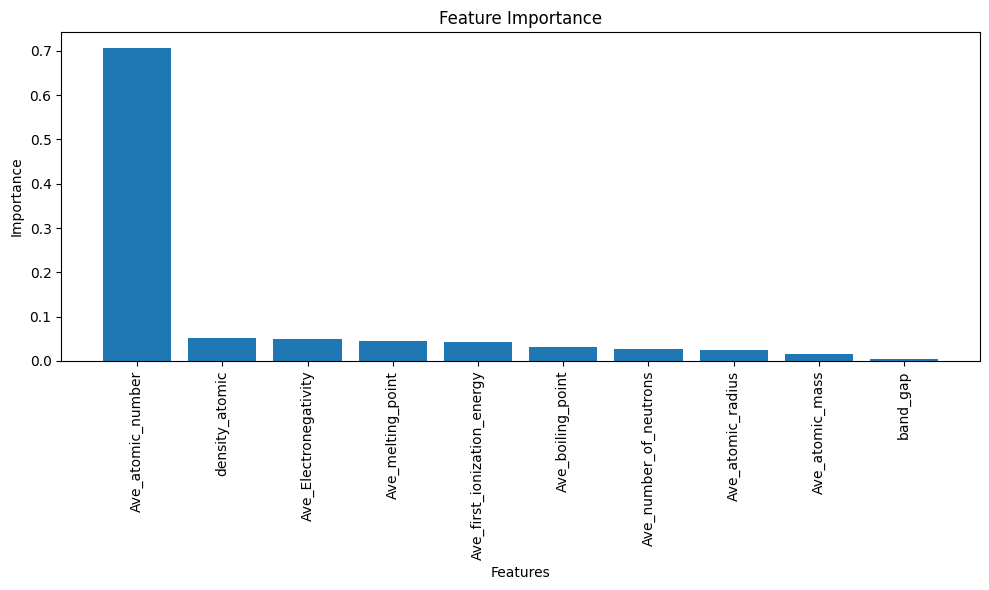

In [28]:
##Feature importance for a random forest regressor model
# Extract the feature names
feature_names = df1.columns[:-1]  # Assuming the target variable is in the last column
# Split the data into features (X) and target variable (y)
X = df1.iloc[:, :-1]  # Assuming the target variable is in the last column
y = df1.iloc[:, -1]   # Assuming the target variable is in the last column
# Fit a Random Forest regressor
clf = RandomForestRegressor()
clf.fit(X, y)
# Get feature importances
importances = clf.feature_importances_
# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

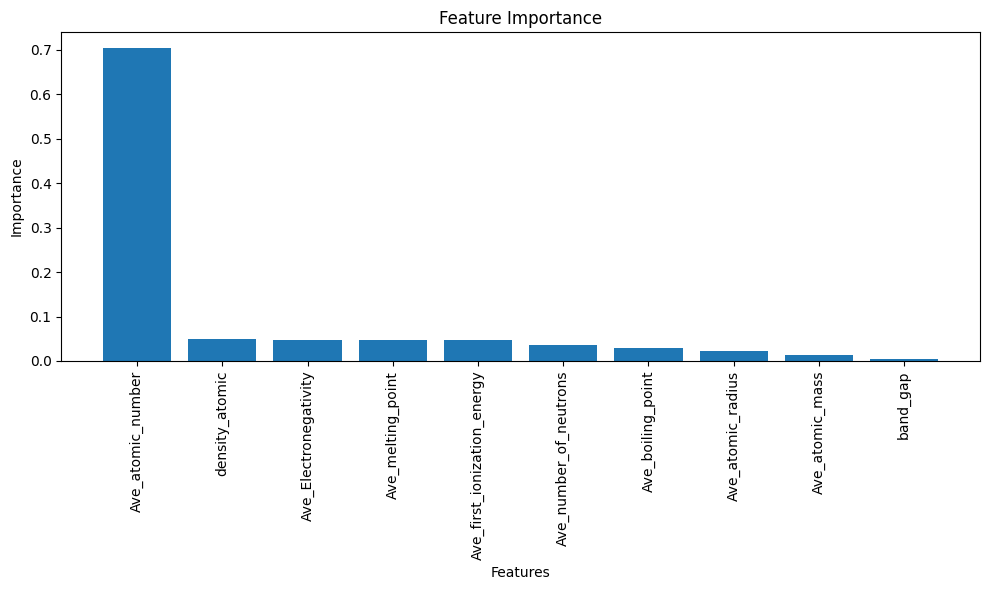

In [29]:
##Feature importance for a decison Tree Regressor model
# Extract the feature names
feature_names = df1.columns[:-1]  # Assuming the target variable is in the last column
# Split the data into features (X) and target variable (y)
X = df1.iloc[:, :-1]  # Assuming the target variable is in the last column
y = df1.iloc[:, -1]   # Assuming the target variable is in the last column
# Fit a Decision Tree regressor
clf = DecisionTreeRegressor()
clf.fit(X, y)
# Get feature importances
importances = clf.feature_importances_
# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Random FOrest regressor model

Feature imp - decision tree classification model

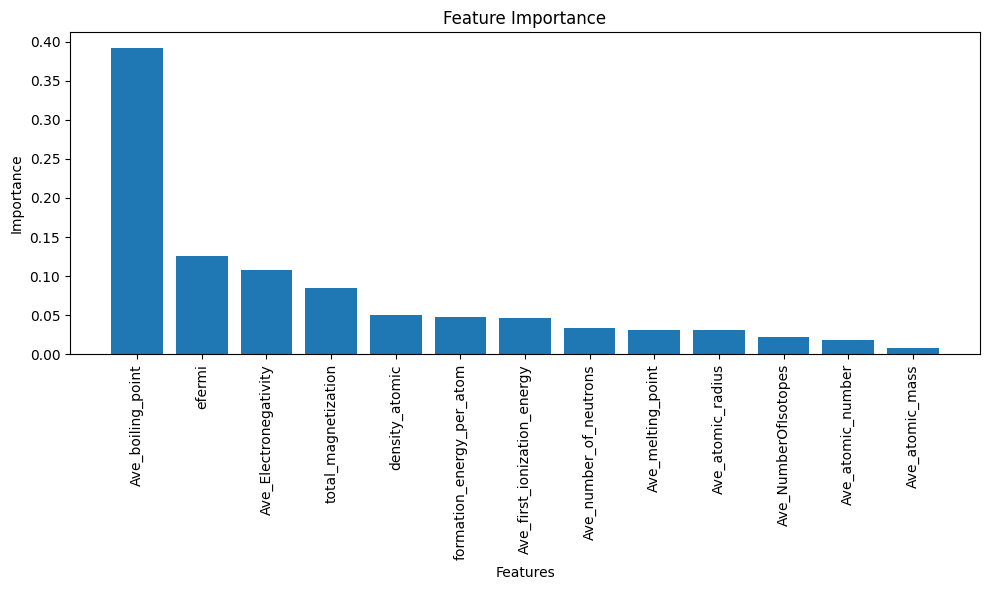

In [30]:
##Feature importance for a decision tree classification model
# Extract the feature names
feature_names = df2.columns[:-1]  # Assuming the target variable is in the last column
# Split the data into features (X) and target variable (y)
X = df2.iloc[:, :-1]  # Assuming the target variable is in the last column
y = df2.iloc[:, -1]   # Assuming the target variable is in the last column
# Fit a Random Forest regressor
clf = DecisionTreeClassifier()
clf.fit(X, y)
# Get feature importances
importances = clf.feature_importances_
# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Feature importance Random forest classification model

For each classification/regression model, find the composition-averaged features that have the strongest effect on predicted properties (i.e., metallicity and formation energy). What are the features that do not contribute to your models? Try to explain the observed correlations using domain knowledge. Describe the drawbacks of used models and suggest possible strategies to increase their predictive power. What kind of information about materials (i.e., new features) can improve the predictive power of your model but is not available?

or each classification/regression model, find the composition-averaged features that have the strongest effect on predicted properties (i.e., metallicity and formation energy)

-> Linear regression based on coefficients - Atomic mass , Isotopes, Boiling, melting points and total magnetization

decison Tree Regressor model - Atomic number, atomic density, melting point , first ionization energy

Random FOrest regressor model - atomic number, atomic density, electronegativity, melting point, first ionization energy

decision tree classification model - boiling point, fermi energy, electronegativity, total magnetization

Random forest classification model - Boiling point, fermi energy, first ionization energy, electro negativity


It was an observance that bandgap did not contribute formation of energy per atom. Moreover, interestingly formation energy of atom did not contribute much in the classification models.

Metals generally have higher atomic masses compared to nonmetals.Most metals have high boiling points. This is because metallic bonding, which involves the delocalization of electrons among metal atoms, leads to strong interatomic forces and high melting points.

Metals generally have high melting points due to strong metallic bonding. The arrangement of metal atoms in a crystal lattice allows for efficient sharing of delocalized electrons, resulting in strong metallic bonds. Thereby, from the classification models high dependency on boiling point feature is observed.

In terms of model performance, the random forest consistently outperformed the decision tree model and linear regression model this can be observed by the by comparing with the r^2 values of different models and random forest has higher r^2 values. This improvement can be attributed to the random forest being an advanced version of the decision tree algorithm that combines multiple decision trees and takes their average predictions also I believe it is higly beneficial when dealing with unbalanced set of data . The random forest model also provides more opportunities for optimization through hyperparameter tuning, allowing for further enhancements in performance.

The models can be improvised by factoring more electronic structures and thermodynamic properties such as density of states which can provide more insights into electronic behavious and energy levels of the material.